# Ensembles

En esta notebook, veremos de hacer un ensemble neuronal de las técnicas vistas hasta el momento (y quizás alguna más)

Vamos a usar

- Modelo char
- Modelo BoW
- Modelo ElMO


In [1]:
import pandas as pd
import csv

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)

text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500


Hagamos tokenize sobre el texto

In [2]:
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import SnowballStemmer
import unidecode

stemmer = SnowballStemmer('spanish')

def tokenize(tweet, stem=False, deaccent=True, alpha_only=False, **kwargs):
    tokenizer = TweetTokenizer(**kwargs)
    tokens = tokenizer.tokenize(tweet)
    
    ret = []
    
    def fstem(x):
        if stem:
            return stemmer.stem(x)
        else:
            return x
        
    for token in tokens:
        tok = None
        if token[0] == "#":            
            tok = fstem(token[1:])
        elif token[0] == "@":
            tok = "@user"
        elif "http" in token:
            continue
        else:
            tok = fstem(token)
        
        if deaccent and tok.isalpha():
            tok = unidecode.unidecode(tok)
        if alpha_only and not tok.isalpha():
            continue
        
        ret.append(tok)
    return ret



Using TensorFlow backend.


## Bow Model

In [3]:

tokenize_args = {"preserve_case": False, "reduce_len": True, "strip_handles": False}

vect = CountVectorizer(tokenizer=lambda t: tokenize(t, stem=True, **tokenize_args), 
                       max_df=0.90, min_df=0.001, ngram_range=(1, 2), binary=True)

vect.fit(df_train["text"])

X_bow_train = vect.transform(df_train["text"])
X_bow_dev = vect.transform(df_dev["text"])

## Char Input

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 200


tokenize_args = {
    "preserve_case": False, 
    "deaccent": True,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": True,
    "alpha_only": False
}

text_train = [" ".join(tokenize(t, **tokenize_args)) for t in df_train["text"].values]
text_dev = [" ".join(tokenize(t, **tokenize_args)) for t in df_dev["text"].values]

char_tokenizer = Tokenizer(num_words=vocab_size, char_level=True, 
                           lower=tokenize_args["preserve_case"])
char_tokenizer.fit_on_texts(text_train)

X_char_train = char_tokenizer.texts_to_sequences(text_train)
X_char_dev = char_tokenizer.texts_to_sequences(text_dev)

(array([358., 909., 892., 801., 491., 274., 256., 264., 220.,  35.]),
 array([  5. ,  32.1,  59.2,  86.3, 113.4, 140.5, 167.6, 194.7, 221.8,
        248.9, 276. ]),
 <a list of 10 Patch objects>)

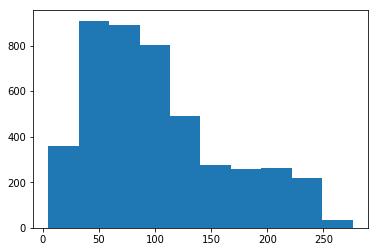

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(seq) for seq in X_char_train])

Sanity check: veamos que si "destokenizo", me reconstruye algo razonable

In [6]:
print(char_tokenizer.sequences_to_texts(X_char_train[0:1]))
print(text_train[0])
print(char_tokenizer.sequences_to_texts(X_char_train[1:2]))
print(text_train[1])

["e a s y j e t   q u i e r   d u p l i c   e l   n u m e r   d e   m u j e r   p i l o t   '   v e r a s   t u   p a r   a p a r c   e l   a v i o n   . ."]
easyjet quier duplic el numer de mujer pilot ' veras tu par aparc el avion ..
['e l   g o b i e r n   d e b   c r e   u n   c o n t r o l   e s t r i c t   d e   i n m i g r   e n   l a s   z o n   f r o n t e r i z   c o n   c o l o m b i   p o r   q   d e s p u e s   d e l   2 0 - 8   q u e r r a n   v e n   e n   m a s']
el gobiern deb cre un control estrict de inmigr en las zon fronteriz con colombi por q despues del 20-8 querran ven en mas


In [7]:

max_charlen = 300

X_char_train = pad_sequences(X_char_train, maxlen=max_charlen)
X_char_dev = pad_sequences(X_char_dev, maxlen=max_charlen)

## Elmo Input

In [8]:
from keras.utils import to_categorical
import numpy as np

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "alpha_only": True,
}


tokens_train = [tokenize(tweet, **tokenize_args) for tweet in df_train["text"].values]
tokens_dev = [tokenize(tweet, **tokenize_args) for tweet in df_dev["text"].values]

tokens_train[0]

['easyjet',
 'quiere',
 'duplicar',
 'el',
 'número',
 'de',
 'mujeres',
 'piloto',
 'verás',
 'tú',
 'para',
 'aparcar',
 'el',
 'avión']

Ahora, calculemos los inputs de ElMO

(array([505., 959., 927., 772., 417., 336., 285., 200.,  82.,  17.]),
 array([ 1. ,  6.8, 12.6, 18.4, 24.2, 30. , 35.8, 41.6, 47.4, 53.2, 59. ]),
 <a list of 10 Patch objects>)

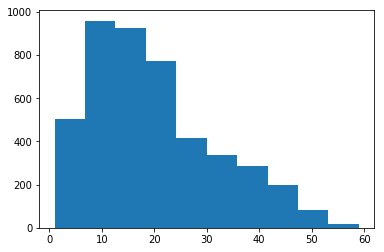

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(t) for t in tokens_train])

Padeamos los vectores con espacios

In [10]:
elmo_max_length = 50

def pad_tokens(tokens, max_len):
    if len(tokens) >= max_len:
        return tokens[:max_len]
    else:
        tokens = tokens + [''] * (max_len - len(tokens))
    return tokens

padded_tokens_train = [pad_tokens(seq, elmo_max_length) for seq in tokens_train]
padded_tokens_dev = [pad_tokens(seq, elmo_max_length) for seq in tokens_dev]


In [11]:
%%capture
from elmoformanylangs import Embedder

e = Embedder("../../../models/elmo/es/")

In [12]:
import numpy as np

print(padded_tokens_train[0])

elmo_dim = 1024

elmo_train = np.array(e.sents2elmo(padded_tokens_train, -1))
elmo_dev = np.array(e.sents2elmo(padded_tokens_dev, -1))

['easyjet', 'quiere', 'duplicar', 'el', 'número', 'de', 'mujeres', 'piloto', 'verás', 'tú', 'para', 'aparcar', 'el', 'avión', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


(array([8.7803e+04, 5.0426e+04, 2.1575e+04, 3.0587e+04, 2.4561e+04,
        8.9640e+03, 1.0070e+03, 7.1000e+01, 4.0000e+00, 2.0000e+00]),
 array([13.045704, 16.202438, 19.359173, 22.51591 , 25.672644, 28.829378,
        31.986113, 35.14285 , 38.299583, 41.456318, 44.613052],
       dtype=float32),
 <a list of 10 Patch objects>)

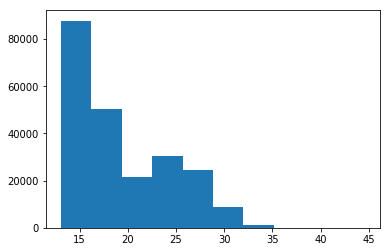

In [13]:
plt.hist([np.linalg.norm(t) for seq in elmo_train for t in seq ])

In [14]:

def pad_vectors(X, max_len, norm=False):
    pad_vector = np.zeros((1, elmo_dim))
    ret = []
    
    for seq in X:
        if norm:
            seq = seq / np.linalg.norm(seq, axis=1)[..., np.newaxis]
        if len(seq) > max_len:
            ret.append(seq[:max_len])
        else:
            padded = np.vstack([
                seq, 
                np.zeros((max_len - len(seq), elmo_dim))
            ])
            
            ret.append(padded)
        
    return ret


X_elmo_train = np.array(pad_vectors(elmo_train, elmo_max_length))
X_elmo_dev = np.array(pad_vectors(elmo_dev, elmo_max_length))

X_elmo_train.shape, X_elmo_dev.shape

((4500, 50, 1024), (500, 50, 1024))

(array([8.7804e+04, 5.0425e+04, 2.1575e+04, 3.0587e+04, 2.4561e+04,
        8.9640e+03, 1.0070e+03, 7.1000e+01, 4.0000e+00, 2.0000e+00]),
 array([13.04570331, 16.20243826, 19.35917321, 22.51590816, 25.67264311,
        28.82937806, 31.98611301, 35.14284797, 38.29958292, 41.45631787,
        44.61305282]),
 <a list of 10 Patch objects>)

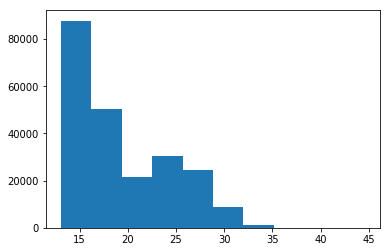

In [15]:
norms = [np.linalg.norm(t) for seq in X_elmo_train for t in seq ]

plt.hist(norms)

## Carguemos los embeddings


import os
import glob
from hate.utils import load_embedding

path_to_embeddings = os.path.expanduser("~/WordVectors")

print("Embeddings disponibles")
print(glob.glob(path_to_embeddings+"/*.vec"))

word_to_vec = load_embedding(os.path.join(path_to_embeddings, "UBA_w5_300.vec"))

## Modelo múltiple inputs
Hagamos un primer modelo con múltiple inputs.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Char_Input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 300, 64)      12800       Char_Input[0][0]                 
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 300, 64)      20544       embedding_10[0][0]               
__________________________________________________________________________________________________
max_pooling1d_10 (MaxPooling1D) (None, 100, 64)      0           conv1d_10[0][0]                  
__________________________________________________________________________________________________
Elmo_Input

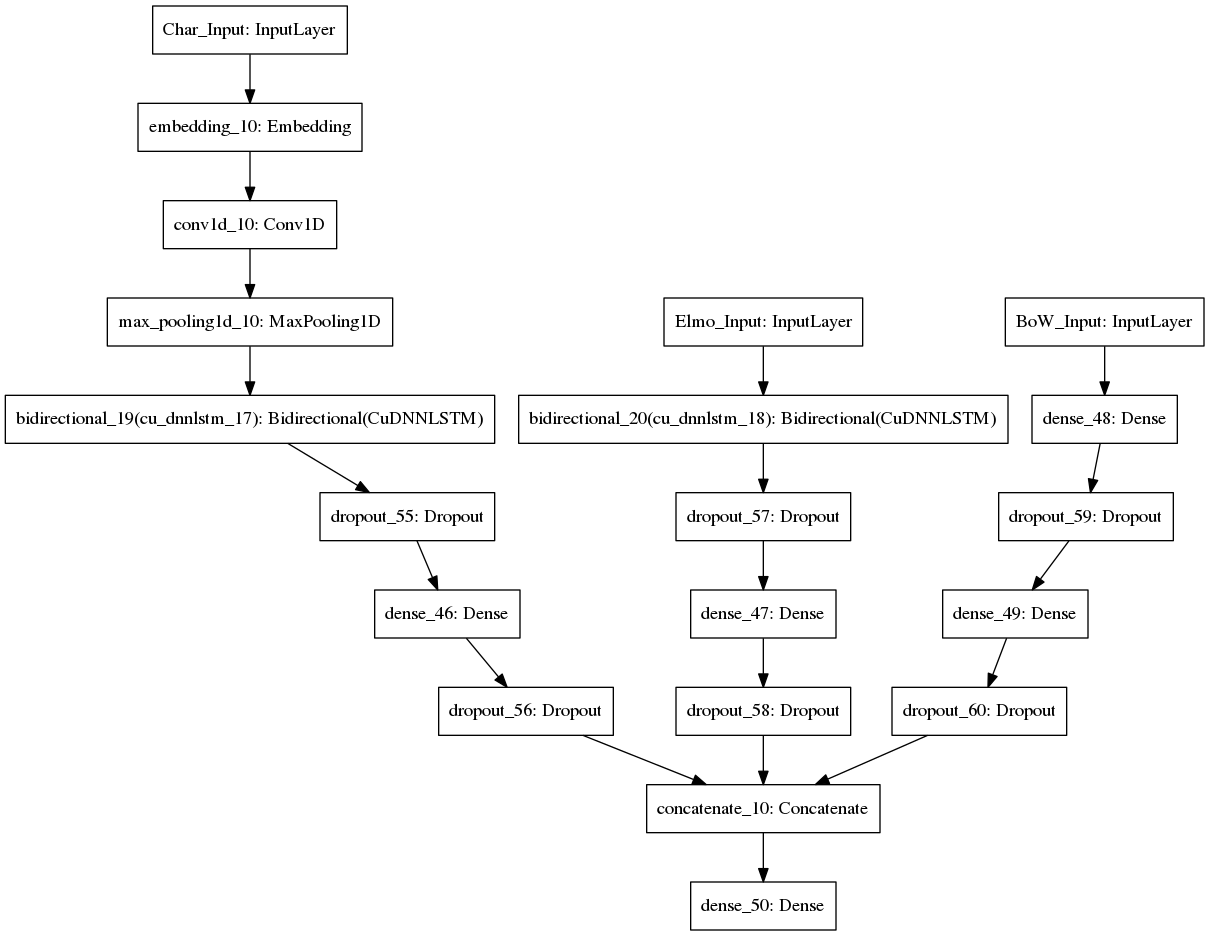

In [35]:
from keras.models import Model
from keras.layers import (
    Dense, GRU, Dropout, LSTM, Bidirectional, Embedding,
    CuDNNLSTM, CuDNNGRU, Conv1D, MaxPooling1D, Input, Concatenate)
from keras.optimizers import Adam
from keras.utils import plot_model

recursive_class = CuDNNLSTM

def create_char_graph(max_charlen, vocab_size, embedding_dim=64, filters=64, kernel_size=5,
                      pooling_size=3, lstm_units=128, dense_units=64, dropout=[0.75, 0.50]):
    input_char = Input(shape=(max_charlen,), name="Char_Input")
    x = Embedding(vocab_size, embedding_dim)(input_char)
    x = Conv1D(filters=filters, kernel_size=kernel_size, 
               padding='same', activation='relu')(x) 
    
    x = MaxPooling1D(pool_size=pooling_size)(x)
    x = Bidirectional(recursive_class(lstm_units))(x)
    x = Dropout(dropout[0])(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout[1])(x)
    
    return input_char, x


def create_elmo_graph(max_length, lstm_units=256, dropout=[0.75, 0.50]):
    input_elmo = Input(shape=(max_length, elmo_dim), name="Elmo_Input")
    y = Bidirectional(recursive_class(lstm_units))(input_elmo)
    y = Dropout(dropout[0])(y)
    y = Dense(128, activation='relu')(y)
    y= Dropout(dropout[1])(y)
    return input_elmo, y

def create_bow_graph(input_shape, dense_units=512, dropout=[0.75, 0.50]):
    input_bow = Input(shape=input_shape, name="BoW_Input")
    z = Dense(dense_units, activation='relu')(input_bow)
    z = Dropout(dropout[0])(z)
    z = Dense(128, activation='relu')(z)
    z = Dropout(dropout[1])(z)
    
    return input_bow, z




dropouts = [0.75, 0.50]

input_char, output_char = create_char_graph(max_charlen, vocab_size, embedding_dim=64, lstm_units=64, dropout=dropouts)
input_elmo, output_elmo = create_elmo_graph(elmo_max_length, lstm_units=128, dropout=dropouts)
input_bow, output_bow = create_bow_graph(input_shape=(X_bow_train.shape[1],), dense_units=256, dropout=dropouts)



use_char = True
use_elmo = True
use_bow = True

X_tr = []
X_dev = []
to_merge = []
inputs = []
if use_char:
    to_merge.append(output_char)
    inputs.append(input_char)
    X_tr.append(X_char_train)
    X_dev.append(X_char_dev)
if use_elmo:
    to_merge.append(output_elmo)
    inputs.append(input_elmo)
    X_tr.append(X_elmo_train)
    X_dev.append(X_elmo_dev)    
if use_bow:
    to_merge.append(output_bow)
    inputs.append(input_bow)
    X_tr.append(X_bow_train)
    X_dev.append(X_bow_dev)


    
if use_char + use_elmo + use_bow >= 2:
    merge_layer = Concatenate()(to_merge)
else:
    merge_layer = to_merge[0]
    
#merge_layer = Dense(64, activation='relu')(merge_layer)
output = Dense(1, activation='sigmoid')(merge_layer)

optimizer_args = {
    "lr": 0.0005,
    "decay": 0.01,
    "amsgrad": False
}



model = Model(inputs=inputs, outputs=[output])
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])


from IPython.display import Image

print(model.summary())


plot_model(model, to_file='model.png')
Image('model.png')

In [36]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('/tmp/ensemble_11.h5', save_best_only=True, monitor='val_acc', verbose=1)

model.fit(X_tr, y_train, callbacks=[checkpointer],
          validation_data=(X_dev, y_dev), epochs=50, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/50
4500/4500 [==============================] - 9s 2ms/step - loss: 0.6751 - acc: 0.5993 - val_loss: 0.6092 - val_acc: 0.7040

Epoch 00001: val_acc improved from -inf to 0.70400, saving model to /tmp/ensemble_11.h5
Epoch 2/50
4500/4500 [==============================] - 5s 1ms/step - loss: 0.5652 - acc: 0.7218 - val_loss: 0.5240 - val_acc: 0.7520

Epoch 00002: val_acc improved from 0.70400 to 0.75200, saving model to /tmp/ensemble_11.h5
Epoch 3/50
4500/4500 [==============================] - 5s 1ms/step - loss: 0.4761 - acc: 0.7822 - val_loss: 0.4784 - val_acc: 0.7840

Epoch 00003: val_acc improved from 0.75200 to 0.78400, saving model to /tmp/ensemble_11.h5
Epoch 4/50
4500/4500 [==============================] - 5s 1ms/step - loss: 0.4113 - acc: 0.8207 - val_loss: 0.4524 - val_acc: 0.8060

Epoch 00004: val_acc improved from 0.78400 to 0.80600, saving model to /tmp/ensemble_11.h5
Epoch 5/50
4500/4500 [==============================

In [38]:
from hate.utils import print_evaluation

model.load_weights('/tmp/ensemble_11.h5')

print_evaluation(model, X_dev, y_dev)

500/500 [==============================] - 0s 682us/step
Loss        : 0.4560
Accuracy    : 0.8320
Precision   : 0.8108
Recall      : 0.8108
F1          : 0.8108


## Error Analysis

Vamos a ver los tweets con mayores errores

In [39]:
df_dev["proba"] = model.predict(X_dev)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_negatives)))
print("Falsos positivos: {}".format(len(false_positives)))

conf_matrix[["pred_true", "pred_false"]]

Falsos negativos: 42
Falsos positivos: 42


,pred_true,pred_false
real,,
hs=1,180,42
hs=0,42,236


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [40]:
pd.set_option('max_colwidth', 300)

false_negatives[["text", "proba"]]


,text,proba
id,,
21072,"Voy andando por la calle y me han dicho cosas en árabe ya que me estas acosando dime lo en español para que te entienda, asique como yo no les entiendo me he cagado en su puta madre en árabe para que ellos a mi si.",0.002435
20711,@lopezdoriga eso es culpa de los gobiernos corruptos que tienen arreglos con esta escoria. Ojalá se muera la perra esa...,0.006168
21215,"Que tal otro aporte anónimo son de la puta de mi esposa, así los dejó en navidad enseñando le los calzones al vecino rt y siguenos @TANGASUCIA @Tangasrobadas https://t.co/70ioUjveqY",0.011587
23716,"- El otro día me comí a Laura es muy fácil que guarra jajajaja - Laura también te comió a ti entonces tú eres igual de guarro e igual de fácil. - Puto feminazi putas modas eres feminista solo para ligar bien queda gilipollas - em, ok",0.014327
21152,@NatyBurgos15 @Horaciogenta @PaolaPa05 Cállate vos Black and bitch como la puta falsa abogada. Espero se pudra en la cárcel y devuelva todo. Dedícate a estudiar en serio. La droga es mala. Cristina puta,0.014808
24925,"La verdad que si, no veia la hora de llegar a los 5 mil amigos😂 ahora de a poco voy borrando esos indios indocumentados😂 https://t.co/Xw8q4GLM8v",0.027104
21887,"@A3Noticias Esta tiene que ser una 'fake new' porque las mujeres son siempre las víctimas, no las hijas de puta maltratadoras. Eso o el chaval es un machista que se lo ha merecido (machete al machote).",0.032376
22065,| lo único que dominas es mi polla en tu cara. https://t.co/qlYOd4zPwW,0.034031
24352,"¿Ves que tu coño me importe? Cómete mi polla, basura https://t.co/ht02KyYWZh",0.074134


¿Cómo los tokenizamos?

In [20]:
df_dev.loc[21841]["text"]

'La otra no noticia del día es la visita del sonriente Casado a Algeciras, a visitar en Ceuta y Algeciras, no a los guardias civiles heridos tras la violenta entrada de ilegales del otro día, sino a un grupo de subsaharianos que han entrado en nuestro país de forma igualmente ileg'

## Elmo y OOV words

¿Qué hace elmo con palabras extrañas como "negratas", "subsaharianos", etc?

In [59]:
vocabulary = e.word_lexicon.keys()

"negratas" in vocabulary

False

In [60]:
"subsahariano" in vocabulary

False

Ok. Estamos perdiendo información con esto

In [51]:
vecs = e.sents2elmo([["negratas"], ["subsahariano"]], 2)

In [52]:
vecs[0].shape, vecs[1].shape

((1, 1024), (1, 1024))

In [57]:
v1 = vecs[0].reshape(-1)
v2 = vecs[1].reshape(-1)

sim = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))

sim

0.7698738

## Falsos negativos

In [63]:
pd.set_option('max_colwidth', 200)
false_positives[["text", "proba"]]

,text,proba
id,,
24159,"@LeonDeJapon Jajajajajaja tu eres uno, diego jajajajajaja mentira perra perra perrraaaaaaaaaa de mierda jajaja ♡",0.958672
22517,"-¿eres poblana? -soy colombiana -¿y por qué eres güera? en Colombia TODAS son morenas, fui a Colombia 3 veces. -ok, mentí 🙄 solo me pinto el cabello",0.955924
21966,"escúchame ya me jodería jajajajajajajajajajajajajaja si pa ti enseñar es ser una guarra yo soy biennnn guarra, menos mal que no me respeto que si no... https://t.co/yt5fHp99b7",0.946862
21050,@GvyMC @Wismichu Callate puta rata😂😂 ya estas llorando??,0.944250
22416,@Pepe_ElEzequiel Puta!? Puta con las que vos te metes Esa mujer es un ángel enviado por Jesucristo nuestro señor para darnos esa paz que buscamos sólo con verla,0.941651
24402,zorra eres tu que no te sientes hombre y no entiendes que toda mujer es bella,0.930660
22457,"De Colombia tocará emigrar en pateras, como hacen los africanos subsaharianos.",0.920149
24529,@desoir2525 Cállate rata MUDera.eres escoria.,0.908138
21892,@saancisco Callate puta tu eres el traidor.,0.878067


## Usando las traducciones?

Probemos, ya que estamos...

# Conclusiones

Sirvió mejorar el preprocesamiento. Quedamos en pérdida ~0.43

No estarían convenciendo las traducciones...

Diría que intentemos un ensemble con caracteres o n-gramas.